In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import sys

# change with your project path
%cd /content/drive/MyDrive/Photo_Math_Project
sys.path.append('./utils/')

In [3]:
from IPython.display import clear_output
!pip install transformers
!pip install sentencepiece
!pip install -q datasets jiwer
!pip install python-Levenshtein
!pip install pylatexenc
clear_output()

In [ ]:
import sys
sys.path.append('/content/gdrive/mypythondirectory')

In [ ]:
from transformers import TrOCRProcessor, VisionEncoderDecoderModel
from PIL import Image
from pylatexenc.latex2text import LatexNodes2Text
import numpy as np
from utils.inkml import *
import inkml2img as i2i
import pickle
import matplotlib.pyplot as plt
import Levenshtein as lev

## Preparing the data

In [ ]:
with(open('./inkml_datasets/train_inkml.pkl', 'rb')) as f:
    train_list = pickle.load(f)

with(open('./inkml_datasets/test_inkml.pkl', 'rb')) as f:
    test_list = pickle.load(f)

### Data augmentation demo

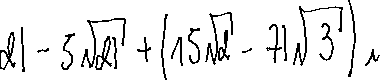

true label: $21-5\sqrt{21}+(15\sqrt{7}-21\sqrt{3})i$, augment: $21-5\sqrt{21}+(15\sqrt{2}-71\sqrt{3})i$


In [ ]:
img, label = train_list[3].augmentRandomSymbol(train_list[3], n_changes=100)
display(img)
print(f'true label: {train_list[3].truth.replace(" ", "")}, augment: {str(label).replace("backslash ", "").replace("mathrm","")}')

In [ ]:
token_dict = {
        "\alpha": "[ALPHA]",
        "\beta": "[BETA]",
        "\gamma": "[GAMMA]",
        "\phi": "[PHI]",
        "\pi": "[PI]",
        "\theta": "[THETA]",
        "\infty": "[INFINITY]",
        "+": "[PLUS]",
        "-": "[MINUS]",
        "\pm": "[PLUSMINUS]",
        "\div": "[DIV]",
        "\times": "[TIMES]",
        "\sum": "[SUM]",
        "\log": "[LOG]",
        "\sin": "[SIN]",
        "\cos": "[COS]",
        "\tan": "[TAN]",
        "\ldots": "[LDOTS]",
        "\neq": "[NEQ]",
        "\leq": "[LEQ]",
        "\lt": "[LT]",
        "\geq": "[GEQ]",
        "=": "[EQUAL]",
        "\rightarrow": "[ARROW]",
        "\lim": "[LIMIT]",
        "\int": "[INTEGRAL]",
        "(": "[LPAREN]",
        ")": "[RPAREN]",
        "\sqrt": "[SQRT]",
        "!": "[FACTORIAL]",
        "\\underset": "[UNDERSET]",
        "\frac": "[FRAC]",
        "\overset": "[OVERSET]",
        "\{": "[LCBRACK]",
        "\}": "[RCBRACK]",
        "\[": "[LSBRACK]",
        "\]": "[RSBRACK]",
        "\exists": "[EXISTS]",
        "\forall": "[FORALL]",
        "\in": "[IN]"
    }

def decode_latex(text):
    token_dict = {
        "[ALPHA]": "\alpha",
        "[BETA]": "\beta",
        "[GAMMA]": "\gamma",
        "[PHI]": "\phi",
        "[PI]": "\pi",
        "[THETA]": "\theta",
        "[INFINITY]": "\infty",
        "[PLUS]": "+",
        "[MINUS]": "-",
        "[PLUSMINUS]": "\pm",
        "[DIV]": "\div",
        "[TIMES]": "\times",
        "[SUM]": "\sum",
        "[LOG]": "\log",
        "[SIN]": "\sin",
        "[COS]": "\cos",
        "[TAN]": "\tan",
        "[LDOTS]": "\ldots",
        "[NEQ]": "\neq",
        "[LEQ]": "\leq",
        "[LT]": "\lt",
        "[GEQ]": "\geq",
        "[EQUAL]": "=",
        "[ARROW]": "\rightarrow",
        "[LIMIT]": "\lim",
        "[INTEGRAL]": "\int",
        "[LPAREN]": "(",
        "[RPAREN]": ")",
        "[SQRT]": "\sqrt",
        "[FACTORIAL]": "!",
        "[UNDERSET]": "\\underset",
        "[FRAC]": "\frac",
        "[OVERSET]": "\overset",
        "[LCBRACK]": "\{",
        "[RCBRACK]": "\}",
        "[LSBRACK]": "\[",
        "[RSBRACK]": "\]",
        "[EXISTS]": "\exists",
        "[FORALL]": "\forall",
        "[IN]":"\in",
    }
    for token, symbol in token_dict.items():
        text = text.replace(token, symbol)

    return text

In [ ]:
def encode_latex(latex):
    global token_dict

    # Replace LaTeX symbols with custom tokens
    for symbol, token in token_dict.items():
        latex = latex.replace(symbol, token)

    return latex

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
import random
import torchvision.transforms as transforms
class CustomDataset(Dataset):
  def __init__(self, inkml_list, processor, latex_encoder, training = True):
    self.inkml_list = inkml_list
    self.processor = processor
    self.latex_encoder = latex_encoder
    self.training = training
    self.transform = transforms.Compose([
      transforms.RandomRotation(degrees=(-10,10), fill=(255,))
    ])

  def __len__(self):
    return len(self.inkml_list)

  def __getitem__(self, idx):
    #50% of the time augment
    if random.random() < 0.5 and self.training:
      other_id = random.randint(0,len(self.inkml_list)-1)
      # random padding
      padding_y = random.randint(10,50)
      padding_x = random.randint(5,25)
      try:
        img, formula = self.inkml_list[idx].augmentRandomSymbol(
            self.inkml_list[other_id],
            n_changes = 100,
            image_w = 384,
            image_h = 384,
            padding_x = padding_x,
            padding_y = padding_y,
            thickness=2
          )
      except:
        strokes = [v for k, v in self.inkml_list[idx].strokes.items()]
        img = i2i.create_seg_img(strokes, image_w = 384, image_h = 384, padding_y=padding_y, padding_x=padding_x,thickness =2)
        formula = self.inkml_list[idx].truth
    else:
      strokes = [v for k, v in self.inkml_list[idx].strokes.items()]
      img = i2i.create_seg_img(strokes, image_w = 384, image_h = 384, thickness =2)
      formula = self.inkml_list[idx].truth

    formula = self.latex_encoder(formula).replace(" ", "")


    if self.training:
      img = self.transform(img)

    img = np.array(img)
    img = np.expand_dims(img, axis = 0)
    img = np.repeat(img, 3, axis=0)

    # processor
    pixel_values = self.processor(img, return_tensors = "pt").pixel_values
    labels = self.processor.tokenizer(
        formula,
        padding="max_length",
        max_length=128,
        truncation = True).input_ids

    labels = [label if label != self.processor.tokenizer.pad_token_id else -100 for label in labels]
    encoding = {"pixel_values": pixel_values.squeeze(), "labels": torch.tensor(labels)}
    return encoding

## Model

In [ ]:
processor = TrOCRProcessor.from_pretrained('microsoft/trocr-large-handwritten')
processor.tokenizer.add_tokens(list(token_dict.values()))

model = VisionEncoderDecoderModel.from_pretrained('./Models/finetune-trocr-large')
model.decoder.resize_token_embeddings(len(processor.tokenizer))

### Testing if the datasets are working

In [ ]:
train_dataset = CustomDataset(train_list, processor,encode_latex)
val_dataset = CustomDataset(test_list, processor,encode_latex, training=False)

In [ ]:
print("Number of training examples:", len(train_dataset))
print("Number of validation examples:", len(val_dataset))

Number of training examples: 921
Number of validation examples: 348


In [ ]:
def decode_labels(x, processor):
  x[x == -100] = processor.tokenizer.pad_token_id
  x_str = processor.decode(x, skip_special_tokens=True)

  return x_str

In [ ]:
encoding = train_dataset[5]
for k,v in encoding.items():
  print(k, v.shape)

pixel_values torch.Size([3, 384, 384])
labels torch.Size([128])


Text(0.5, 1.0, 'cos(9×6)=cos9cos6-sin2sin0')

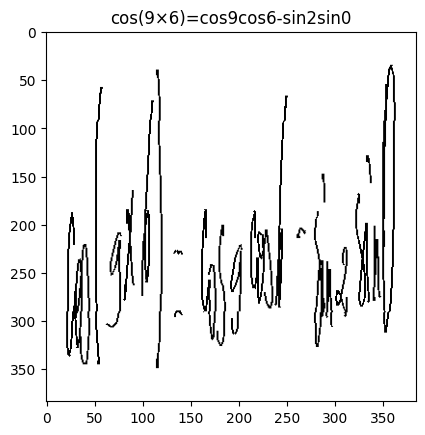

In [ ]:
plt.imshow(encoding["pixel_values"].transpose(0,2).transpose(0,1))
plt.title(LatexNodes2Text().latex_to_text(decode_latex(decode_labels(encoding["labels"],processor))))

## Train the model

In [ ]:
batch_size = 16
train_dataloader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True, num_workers = 2, pin_memory = True)
val_dataloader = DataLoader(val_dataset, batch_size = batch_size, num_workers = 2, pin_memory = True)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

In [ ]:
model.config.decoder.dropout = 0.5
model.config.encoder.dropout = 0.5

In [ ]:
# set special tokens used for creating the decoder_input_ids from the labels
model.config.decoder_start_token_id = processor.tokenizer.cls_token_id
model.config.pad_token_id = processor.tokenizer.pad_token_id
# make sure vocab size is set correctly
model.config.vocab_size = model.config.decoder.vocab_size = len(processor.tokenizer)

# set beam search parameters
model.config.eos_token_id = processor.tokenizer.sep_token_id
model.config.max_length = 256
model.config.early_stopping = True
model.config.no_repeat_ngram_size = 5
model.config.length_penalty = 1.0
model.config.num_beams = 4

In [ ]:
from torch.optim.lr_scheduler import StepLR
optimizer = torch.optim.AdamW(model.parameters(), lr=6e-5, weight_decay=0.001)
scheduler = StepLR(optimizer, step_size=3, gamma=0.8)

In [ ]:
# early stopping params
patience = 5
best_val_loss = float('inf')
early_stop_count = 0

In [ ]:
from tqdm import tqdm

train_loss_hist = []
test_loss_hist = []

num_epochs = 65
save_path = './Models/finetune-trocr-large/'

#freeze the encoder
for param in model.encoder.parameters():
    param.requires_grad = False

for epoch in range(num_epochs):

  if epoch+1 == 10:
    for param in model.encoder.parameters():
      param.requires_grad = True

  model.train()
  train_loss = 0.0
  pbar = tqdm(train_dataloader)
  for batch in pbar:

    for k,v in batch.items():
        batch[k] = v.to(device)

    optimizer.zero_grad()
    outputs = model(**batch)
    loss = outputs.loss
    loss.backward()
    optimizer.step()

    train_loss += loss.item()

  train_loss /= len(train_dataloader)
  scheduler.step()

  model.eval()
  edit_distance = 0
  val_loss = 0.0
  with torch.no_grad():
    for batch in tqdm(val_dataloader):

      for k,v in batch.items():
        batch[k] = v.to(device)

      outputs = model(**batch)
      val_loss += outputs.loss.item()

      predicted_ids = outputs.logits.argmax(dim=-1)

      # get the string from tokens
      predicted_ids[predicted_ids == -100] = processor.tokenizer.pad_token_id
      batch["labels"][batch["labels"] == -100] = processor.tokenizer.pad_token_id

      predicted_texts = processor.batch_decode(predicted_ids, skip_special_tokens=True)
      target_texts = processor.batch_decode(batch["labels"], skip_special_tokens=True)

      # Compute edit distance for each pair of predicted and target texts
      edit_distance += sum(lev.distance(decode_latex(pred), decode_latex(target)) for pred, target in zip(predicted_texts, target_texts))

  val_loss /= len(val_dataloader)
  edit_distance /= len(val_dataloader)

  # check for early stopping
  if val_loss < best_val_loss:
      best_val_loss = val_loss
      early_stop_count = 0
  else:
      early_stop_count += 1
      if early_stop_count >= patience:
          print(f"Early stopping after {epoch + 1} epochs")
          break

  # add loss to history
  train_loss_hist.append(train_loss)
  test_loss_hist.append(val_loss)

  print(f"Epoch {epoch+1} | train loss: {train_loss} | val loss: {val_loss} | edit distance : {edit_distance}")

  if best_val_loss == val_loss:
    model.save_pretrained(save_path)
    print('saved model at ' + save_path)

# save train values
with open('./Loss_data/trocr_loss_data.pkl', 'wb') as file:
  pickle.dump((train_loss_hist,test_loss_hist), file)

## Inference

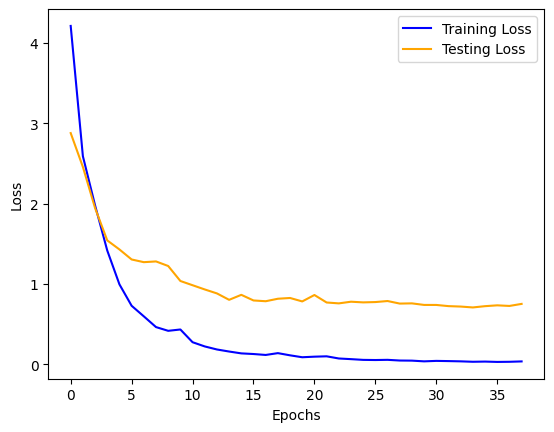

In [ ]:
import matplotlib.pyplot as plt
with open('./Loss_data/trocr_loss_data.pkl', 'rb') as file:
    train_loss_hist, test_loss_hist = pickle.load(file)


plt.plot(train_loss_hist, label='Training Loss', color='blue')

plt.plot(test_loss_hist, label='Testing Loss', color='orange')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

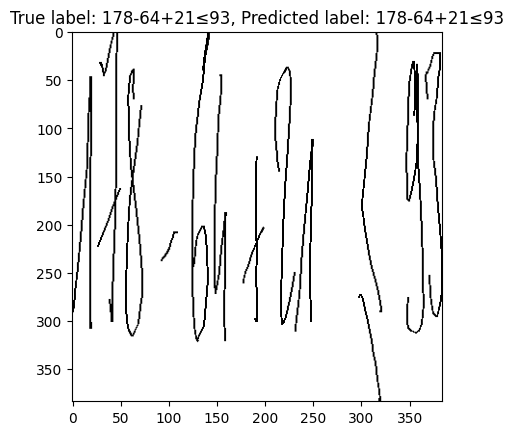

In [ ]:
model.eval()
with torch.no_grad():
  batch = next(iter(val_dataloader))
  idx = 11
  img = batch["pixel_values"][idx].to(device)
  true_label = batch["labels"][idx]

  pred_label = model.generate(img.unsqueeze(0))

  #decode labels
  true_str = decode_labels(true_label, processor)
  generated_text = processor.batch_decode(pred_label, skip_special_tokens=True)[0]

  plt.imshow(img.detach().cpu().numpy().transpose(1,2,0))
  plt.title(f"True label: {LatexNodes2Text().latex_to_text(decode_latex(true_str))}, Predicted label: {LatexNodes2Text().latex_to_text(decode_latex(generated_text))}")


## Accuracy on part 2

In [ ]:
def edit_distance_ids(ids1, ids2, ret_subs=False):
  """
  Computes edit distance between 2 lists of tokens
  dp(i,j) = minimum edit distance for sublists ids1[i:] and ids2[j:]
  dp(i,j) = 1 + min( dp[i,j+1], dp[i+1,j]), dp[i+1,j+1] )

  ret_subs: if list of characters that are substituted should be returned

  Returns edit distance
  """
  n = len(ids1)
  m = len(ids2)

  dp = [[0] * (m+1) for _ in range(n+1)]

  for j in range(m, -1, -1):
    for i in range(n, -1, -1):

      #print(i,j)

      if i == n or j == m:
        dp[i][j] = max(n-i, m-j)
      elif ids1[i] == ids2[j]:
        dp[i][j] = dp[i+1][j+1]
      else:
        dp[i][j] = 1 + min( dp[i][j+1], dp[i+1][j], dp[i+1][j+1])

  if ret_subs:
    #find supstitutions
    subs = []
    i = 0
    j = 0
    while i != n and j != m:
      # if we dont need to change ids1, ids2 on index i,j
      if dp[i][j] == dp[i+1][j+1]:
        i+=1
        j+=1
      # find what is the optimal op to do
      else:
        dop = dp[i+1][j] #delete op
        iop = dp[i][j+1] #insert op
        sop = dp[i+1][j+1] #change op

        min_op = min(sop, iop, dop)

        if sop == min_op:
          subs.append((ids1[i], ids2[j]))
          i+=1
          j+=1
        elif iop == min_op:
          j+=1
        else:
          i+=1

    return dp[0][0], subs

  else:
    return dp[0][0]


In [ ]:
model.eval()
correct = 0

# edit distance bar plot
ed_gram = np.zeros((130, ))

# confusion matrix
predicted = []
truth = []

total = 0
with torch.no_grad():
    for batch in val_dataloader:
        for k,v in batch.items():
          batch[k] = v.to(device)

        outputs = model.generate(**batch)

        outputs[outputs == -100] = processor.tokenizer.pad_token_id
        batch["labels"][batch["labels"] == -100] = processor.tokenizer.pad_token_id

        outputs = processor.batch_decode(outputs, skip_special_tokens=True)
        target_texts = processor.batch_decode(batch["labels"], skip_special_tokens=True)

        total += len(outputs)

        for i in range(len(outputs)):

          pretty_latex1 = LatexNodes2Text().latex_to_text(decode_latex(outputs[i]))
          pretty_latex2 = LatexNodes2Text().latex_to_text(decode_latex(target_texts[i]))

          ed, subs = edit_distance_ids(
              pretty_latex1,
              pretty_latex2,
              ret_subs = True
          )

          for sub in subs:
            predicted.append(sub[0])
            truth.append(sub[1])

          ed_gram[ed]+=1
          if i%2==0:
            print(pretty_latex1, " |||| " , pretty_latex2, " ||| ", ed)

accuracy = 100 * ed_gram[0] / total
print("Model accuracy: ", accuracy)

a+b+b+c^2+e+a+b+c  ||||  a^2+b^2/a+b+b^2+c^2/b+c+c^2+a^2/c+a+b+c  |||  23
(37×(28-126))-70≤-3793  ||||  (38×(28-126))-70≤-3793  |||  1
179-158-4-130=155  ||||  179-158-4-130=155  |||  0
k_y=k^isind  ||||  k_y=ksinθsinϕ  |||  4
8×122≥975  ||||  8×122≥975  |||  0
((151+38)×(11×111)-98≤2306  ||||  ((151+38)×(11×111))-98≤230671  |||  3
63-187≠-169  ||||  63-187≠-169  |||  0
2_3=15  ||||  e_3=15  |||  1
x=1  ||||  x=1  |||  0
cos(π)=1  ||||  cos(π)=-1  |||  1
e^iπ=-1  ||||  e^iπ=-1  |||  0
x  ||||  x  |||  0
axx^2+bxy+c^2  ||||  ax^2+bxy+cy^2  |||  2
2^-1  ||||  2^-1  |||  0
ax^2=c  ||||  ax^2=c  |||  0
2^i3  ||||  2π/3  |||  2
4_1-2_12  ||||  4_12_12  |||  1
x^3+3(2-√(3)^2-3x-2+√(3)  ||||  x^3+3(2-√(3))x^2-3x-2+√(3)  |||  2
5/2√(5+2√(5))  ||||  5/2√(5+2√(5))  |||  0
222_21  ||||  222_1  |||  1
4/3γ  ||||  4/3π  |||  1
2_-1  ||||  2=1  |||  2
2=1+1  ||||  2=1+1  |||  0
y+√(2)  ||||  1+√(2)  |||  1
α_1=1  ||||  d=1  |||  3
π=√(-1)  ||||  i=√(-1)  |||  1
e^iπ=-1  ||||  e^iπ=-1  |||  0
4_c=2√(

cos(π)=-1  ||||  cos(π)=-1  |||  0
2^2/π=1/33  ||||  2/1/3/2=4/3  |||  7
y_i=a_x+b_i  ||||  y_i=ax_i+b  |||  4
%s/%s√(3)√(3)  ||||  √(3)/3  |||  8
2^2+1  ||||  2^2^1+1  |||  2
(a+b)=α^2+b^2+2ab  ||||  (a+b)^2=a^2+b^2+2ab  |||  3
n  ||||  n+i  |||  2
1≠1/π1+2^4/$  ||||  1+1/1+1/1  |||  6


%s/%s√(3)+1/√(2)  ||||  √(3)/2+1/2i  |||  10
n(n-3)  ||||  n(n-3)/2  |||  2
1/x^2  ||||  -1/x^2  |||  1
c=k=xn∑1/x!  ||||  c=i=1n∑x_ia_i  |||  8
1+i  ||||  1+i  |||  0
y=d/a  ||||  y=d/a  |||  0
1/b^+1  ||||  1/b+1  |||  1
n+2/∑  ||||  n+2/2  |||  1
x_(β)  ||||  x^(k)  |||  2
x^4-xx^2  ||||  x^4-x^2  |||  1
(a+b)^2=a^2+2aβ+b^2  ||||  (a+b)^2=a^2+2ab+b^2  |||  1
sin(x)=sin(y)  ||||  sin(x)=sin(y)  |||  0
an^n-n-1  ||||  anx^n-1  |||  3
y(k)  ||||  y^(k)  |||  1
1/2  ||||  π/2  |||  1
c^2=1/2^2  ||||  c^2=1/2d^2  |||  1
γ^-12  ||||  γ_12  |||  2
1-1/3=3^3  ||||  1-1/3=2/3  |||  2
sin(1)  ||||  sin(1)  |||  0
π(x)=π(y)  ||||  π(x)=π(y)  |||  0
x_n=b  ||||  x_n=b  |||  0
3/-22  ||||  3^1/2/2  |||  4
3+2√(2)  ||||  3+2√(2)  |||  0
c_1+c_4=2_i3  ||||  i_1+i_4=i_2+i_3  |||  6
y^n-1  ||||  y^n-1  |||  0
n_2+0_0+n_k=n  ||||  n_1+…+n_k=n  |||  4
j^4=4  ||||  i^4=1  |||  2
log_99=1  ||||  log_aa=1  |||  2
√(1+x)^2  ||||  √(1+x^2)  |||  2
-√(y)  ||||  -√(y)  |||  0
x=π  ||||  x=a  |||  1
y=x^2  ||

2^-1  ||||  2^-1  |||  0
1/-x+x^2  ||||  1/1-x+x^2/2  |||  3
1/3πππ2  ||||  4/3πab^2  |||  4
x=1/3  ||||  x=1/3  |||  0
y^2=x^3+ax+b  ||||  y^2=x^3+ax+b  |||  0
y=x^n  ||||  y=x^n  |||  0
n=b-a+1  ||||  n=b-a+1  |||  0
x^3=x^2+x+1  ||||  x^3=x^2+x+1  |||  0
x/x  ||||  x/c  |||  1
C/b  ||||  c/b  |||  1
cos(π)=-1  ||||  cos(π)=-1  |||  0
a+b  ||||  a+b  |||  0
2^e-1  ||||  2^e-1  |||  0
4_ia^3  ||||  4π^2a^3  |||  3
π+i2  ||||  i_1+i_2  |||  4
ak+n  ||||  ak+n  |||  0


√(a+b√(c=d+e√(c)))  ||||  √(a+b√(c))=d+e√(c)  |||  4
%s/%s1+√(j)√(3)  ||||  -1+i√(3)/2  |||  11
1/αa^2  ||||  1/d^2  |||  2
π(-1)^n  ||||  ∑(-1)^n/n  |||  3
x=j=1k∑∑1/k  ||||  x=i=1k∑a_ie_i  |||  7
2/5  ||||  5/2  |||  2
sin(2i-1)=n^2  ||||  i=1n∑(2i-1)=n^2  |||  4
y=x^2+1/x  ||||  y=x^2+1/x  |||  0
2^2-i  ||||  2^n-1  |||  2
(a+b)^2=a^2+2ab+b^2  ||||  (a+b)^2=a^2+2ab+b^2  |||  0
n^(1)  ||||  n^(1)  |||  0
a_n=1  ||||  a_n=1  |||  0
(a+b)^2=a^2+2ab+b^2  ||||  (a+b)^2=a^2+2ab+b^2  |||  0
x+x/3+1/5!+0∞  ||||  x+x^3/3!+x^5/5!+…  |||  8
a  ||||  a  |||  0
j→-1∞∑1/π  ||||  k=1∞∑a_k/k!  |||  8
axx^2+b_x+c=0  ||||  ax^2+bx+c=0  |||  2
k=k=1/2(n^2+n)  ||||  k=1n∑k=1/2(n^2+n)  |||  3
α^2+b^2)(c^2+α_2)=(ac+bd)  ||||  (a^2+b^2)(c^2+d^2)≥(ac+bd)^2  |||  7
x^n+y^n=z^n  ||||  x^n+y^n=z^n  |||  0
ax^2+bx+c=0  ||||  ax^2+bx+c=0  |||  0
k=k=1/2(n^2+n)  ||||  k=1n∑k=1/2(n^2+n)  |||  3
(a^2+b^2/2)(d^2)=2(ac+b)  ||||  (a^2+b^2)(c^2+d^2)≥(ac+bd)^2  |||  11
x^n+y_n=z_n  ||||  x^n+y^n=z^n  |||  2
ax^2+bx+c=0

x^2+y^2=z^2  ||||  x^2+y^2=z^2  |||  0
a+b+c+d+e  ||||  a+b+c+d+e/a+b+c+d  |||  8
a_i+aj+ax=b_i  ||||  a_i+a_j+a_k=b_i  |||  3
a^1+b^2+c^3+d4  ||||  a^1+b^2+c^3+d^4  |||  1
x→-0lim%s/%sx^2=0  ||||  x→∞lim1/x^2=0  |||  6
sinα=√(γ)^1-cos^2  ||||  sinα=√(1-cos^2α)  |||  5
x=2_n+i±1/3  ||||  x=2nπ±π/3  |||  4
x→-0lim%s/%s3^x-2  ||||  x→∞lim3x-2/x+3  |||  11


∫x^2-e2xx^x  ||||  ∫x^2-e^2x/x-e^xdx  |||  6
e×(x^x)n  ||||  e^x^-(x/2)^n  |||  7
k=1/k×1/k^k+1  ||||  k=1n∑k+1/a_ka_k+1  |||  7
x^2+y^2=z^2  ||||  x^2+y^2=z^2  |||  0
a+b+c+d+d  ||||  a+b+c+d+e/a+b+c+d  |||  8
a_i+aj+a_k=b_i  ||||  a_i+a_j+a_k=b_i  |||  1
a^1+b^2+c^3+d4  ||||  a^1+b^2+c^3+d^4  |||  1
x→1/0lim1/x^2=0  ||||  x→∞lim1/x^2=0  |||  3


sinα=√(γ)^∑-cos^2α  ||||  sinα=√(1-cos^2α)  |||  5
x=2_n+i±1/3  ||||  x=2nπ±π/3  |||  4
x→3/i-2x+3  ||||  x→∞lim3x-2/x+3  |||  6
∫x/^2-ee^2x  ||||  ∫x^2-e^2x/x-e^xdx  |||  9
e^x-(x^x)  ||||  e^x^-(x/2)^n  |||  5
k=1k+1/k^a+1  ||||  k=1n∑k+1/a_ka_k+1  |||  7
x^2+y^2=z^2  ||||  x^2+y^2=z^2  |||  0
a+b+c+d+d  ||||  a+b+c+d+e/a+b+c+d  |||  8


a_i+aj+a_k=b_i  ||||  a_i+a_j+a_k=b_i  |||  1
a^1+b^2+c^3+α^4  ||||  a^1+b^2+c^3+d^4  |||  1
x→-0lim%s/%sx^2=0  ||||  x→∞lim1/x^2=0  |||  6
sinα=√(π)-cos^2α  ||||  sinα=√(1-cos^2α)  |||  3
x=2nπ±1/π  ||||  x=2nπ±π/3  |||  2
x→-1lim3^0-2/$  ||||  x→∞lim3x-2/x+3  |||  7
∫x/^2-ee^2x  ||||  ∫x^2-e^2x/x-e^xdx  |||  9
e^x-c^x)  ||||  e^x^-(x/2)^n  |||  7


k=1/k+1/k^k+1  ||||  k=1n∑k+1/a_ka_k+1  |||  6
x^2+y^2=z^2  ||||  x^2+y^2=z^2  |||  0
a+b+c+d+e  ||||  a+b+c+d+e/a+b+c+d  |||  8
a_i+aj+a_k=b_i  ||||  a_i+a_j+a_k=b_i  |||  1
a^1+b^2+c^3+d^4  ||||  a^1+b^2+c^3+d^4  |||  0
x→-1limx^2/=0  ||||  x→∞lim1/x^2=0  |||  5
sinα=√(π)-cos^2α  ||||  sinα=√(1-cos^2α)  |||  3
x=2nπ±1/π  ||||  x=2nπ±π/3  |||  2
x→-1lim3^3-2/$  ||||  x→∞lim3x-2/x+3  |||  7
∫x/^2-ee^2x  ||||  ∫x^2-e^2x/x-e^xdx  |||  9
e^x-(x^x)n  ||||  e^x^-(x/2)^n  |||  4
k→k/∑k+1k^k+1  ||||  k=1n∑k+1/a_ka_k+1  |||  8
z=1+cos2+isinz∞  ||||  z=1+cos2θ+isin2θ  |||  3
(A)  ||||  (A)  |||  0
Model accuracy:  27.298850574712645


In [ ]:
ed_gram

array([95., 66., 42., 42., 18., 14., 16., 12., 15.,  7.,  2.,  5.,  0.,
        1.,  6.,  2.,  3.,  1.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.])

Text(0, 0.5, 'count')

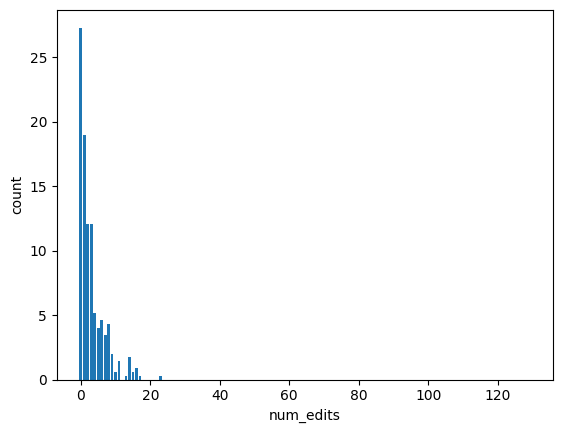

In [ ]:
plt.bar(range(len(ed_gram)), ed_gram/(ed_gram.sum())*100.0)
plt.xlabel("num_edits")
plt.ylabel("count")

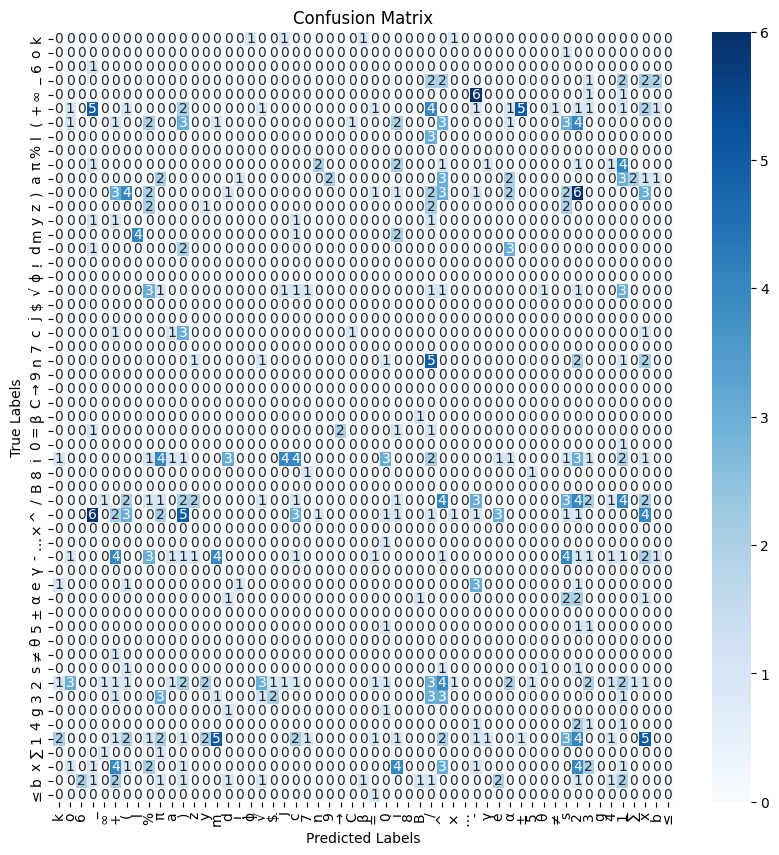

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

unique_labels = list(set(truth + predicted))

cm = confusion_matrix(truth, predicted, labels = unique_labels)

# Plot confusion matrix using seaborn
plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=unique_labels, yticklabels=unique_labels)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()